## Gather data, determine the method of data collection and provenance of the data (1 point)
_In the earliest phase, select a data source and problem. Feel free to share and discuss your idea on the class discussion board._

I discovered a Kaggle dataset titled "Customer Service Chat Data 30k Rows" which contains online chat interactions from a travel company. Currently, there's no system in place to triage these incoming chats. My goal is to develop a model that can automatically identify the emotional tone of each interaction—differentiating between customers who are happy and those who may be dissatisfied. By categorizing chats based on sentiment, we can prioritize urgent cases and ensure that customers experiencing issues receive prompt support.

For reference, the dataset can be found here:
[Customer Service Chat Data 30k Rows](https://www.kaggle.com/datasets/aimack/customer-service-chat-data-30k-rows)

## Identify a Deep Learning Problem (5 points)
_If you're going to use a Kaggle competition or similar, you must focus more on model building and/or analysis to be a valid project. Replicating what's in the Kaggle kernel or other notebooks available online is not a valid project. It is reasonable to add different approaches and compare them with the Kaggle kernel or other notebooks available online. It is also good to find a research paper, implement an algorithm, and run experiments comparing its performance to different algorithms._

I am performing sentiment analysis on chat data to understand the emotional tone of each interaction, which in turn can inform escalation priorities.

I will fine-tune a pre-trained transformer model on a sentiment-labeled dataset. This model will learn to predict whether a chat is positive, negative, or neutral.

Since our customer service chats aren’t tagged with sentiment labels, I found an external dataset—[the Chat Sentiment Dataset on Kaggle](https://www.kaggle.com/datasets/nursyahrina/chat-sentiment-dataset)—which will be used to train our model.

Once trained, the sentiment model will be deployed on our live customer service chat data to automatically gauge customer mood. This information can help identify negative interactions that may require urgent attention or intervention.

The final sentiment analysis model will provide an overall sentiment score for each chat. By understanding the emotional tone—whether the customer chat is positivie, neutral, or negative—we can better prioritize escalations and improve our customer support processes.

## Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data (34 points)
_Go through the initial data cleaning and EDA and judge whether you need to collect more or different data._
_EDA Procedure Example:_
- _Describe the factors or components that make up the dataset (The "factors" here are called "features" in the machine learning term. These factors are often columns in the tabulated data). For each factor, use a box-plot, scatter plot, histogram, etc., to describe the data distribution as appropriate._
- _Describe correlations between different factors of the dataset and justify your assumption that they are correlated or not correlated. You may use numeric or qualitative/graphical analysis for this step._
- _Determine if any data needs to be transformed. For example, if you're planning on using an SVM method for prediction, you may need to normalize or scale the data if there is a considerable difference in the range of the data._
- _Using your hypothesis, indicate if it's likely that you should transform data, such as using a log transform or other transformation of the dataset._
- _You should determine if your data has outliers or needs to be cleaned in any way. Are there missing data values for specific factors? How will you handle the data cleaning? Will you discard, interpolate or otherwise substitute data values?_
- _If you believe that specific factors will be more important than others in your analysis, you should mention which and why. You will use this to confirm your intuitions in your final write-up._

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import re
from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras_tuner as kt

import optuna
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, logging
from datasets import load_dataset, disable_progress_bar

logging.set_verbosity_error()
disable_progress_bar()

random.seed(0)
np.random.seed(0)
np.set_printoptions(suppress=True)

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:
train_data = pd.read_csv('chat_training_dataset.csv')
test_data = pd.read_excel('company_chats_to_triage.xlsx')

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   message    584 non-null    object
 1   sentiment  584 non-null    object
dtypes: object(2)
memory usage: 9.2+ KB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31952 entries, 0 to 31951
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Transaction Start Date    31952 non-null  datetime64[ns]
 1   Agent                     31952 non-null  object        
 2   Chat Duration             31952 non-null  object        
 3   Teams                     31952 non-null  object        
 4   Session Name              31952 non-null  object        
 5   Chat Closed By            31741 non-null  object        
 6   Interactive Chat          31952 non-null  bool          
 7   Browser                   31952 non-null  object        
 8   Operating System          31952 non-null  object        
 9   Geo                       17665 non-null  object        
 10  Response Time of Agent    31952 non-null  object        
 11  Response time of Visitor  31952 non-null  object        
 12  Transaction End Da

In [6]:
import pandas as pd

print(test_data.head())
print(test_data.describe(include=['number', 'datetime']))
print(test_data.isnull().sum())


  Transaction Start Date     Agent Chat Duration                  Teams  \
0    2018-06-08 23:59:00      Zaha      00:18:22    Mobile Service Team   
1    2018-06-08 23:59:00  Berenice      00:03:05  Mobile Technical Team   
2    2018-06-08 23:59:00      Madi      00:22:33    Mobile Service Team   
3    2018-06-08 23:59:00      Rose      00:38:20    Mobile Service Team   
4    2018-06-08 23:59:00    Sarrah      00:11:50     Fixed Service Team   

               Session Name  Chat Closed By  Interactive Chat         Browser  \
0  Session:2057187615:23360        Customer              True   Edge 16.16299   
1  Session:2057187614:23368  Representative             False            Edge   
2  Session:2057187615:23358        Customer              True  c~67.0.3396.87   
3  Session:2057187616:18361          System              True           Other   
4   Session:2057187617:2598  Representative              True           Other   

  Operating System        Geo Response Time of Agent Response 

C:\Users\dusti\AppData\Local\Temp\ipykernel_29928\3857911156.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(test_data.describe(include=['number', 'datetime']))
C:\Users\dusti\AppData\Local\Temp\ipykernel_29928\3857911156.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(test_data.describe(include=['number', 'datetime']))


In [7]:
print(test_data['Agent'].value_counts().head(10))
print(test_data['Teams'].value_counts())
print(test_data['Browser'].value_counts())
print(test_data['Operating System'].value_counts())


John      190
Mark      154
Marie     136
Noel      126
Sienna    116
Jason     116
Chris     102
Dan       101
Liam       96
Dennis     94
Name: Agent, dtype: int64
Mobile Service Team      16688
Sales Team                4916
Fixed Service Team        4435
Mobile Technical Team     2911
Fixed Technical Team      2439
Business Team              563
Name: Teams, dtype: int64
Other                    16489
Chrome                    3094
mobile_safari~11          2054
c~67.0.3396.99            1796
c~68.0.3440.84             989
                         ...  
f~54                         1
c~53.0.2785.109              1
Chrome 64.0.3282.119         1
ucbrowser~11.4.1.1138        1
ucbrowser~12.8.0.1120        1
Name: Browser, Length: 341, dtype: int64
MacOS            4419
11.4.1           4066
Windows          3782
Android 8.0.0    2577
Windows-10       2371
                 ... 
iOS-9.2.1           1
Mac OS-10.7         1
9.2                 1
iOS-7.1.1           1
Android 4.4.3       

In [12]:
import datetime

def duration_to_seconds(duration_val):
    if isinstance(duration_val, str):
        h, m, s = duration_val.strip().split(':')
        return int(h) * 3600 + int(m) * 60 + int(s)
    elif isinstance(duration_val, datetime.time):
        return duration_val.hour * 3600 + duration_val.minute * 60 + duration_val.second
    else:
        return None
test_data['Chat Duration Seconds'] = test_data['Chat Duration'].apply(duration_to_seconds)
print(test_data[['Chat Duration', 'Chat Duration Seconds']].head())


  Chat Duration  Chat Duration Seconds
0      00:18:22                   1102
1      00:03:05                    185
2      00:22:33                   1353
3      00:38:20                   2300
4      00:11:50                    710


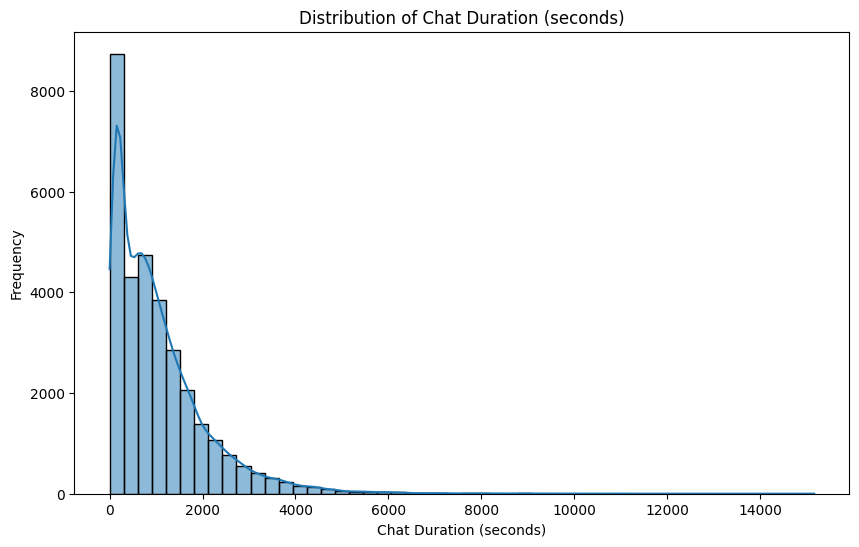

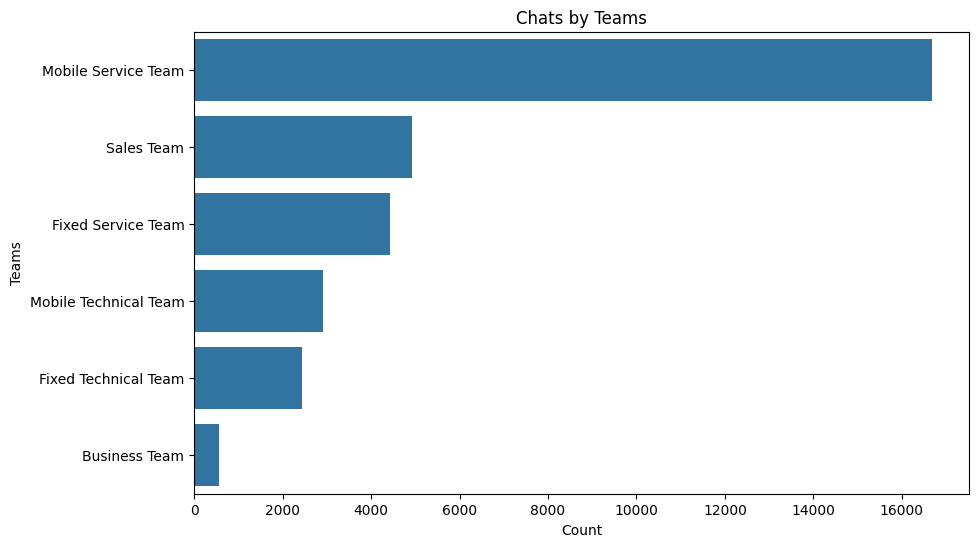

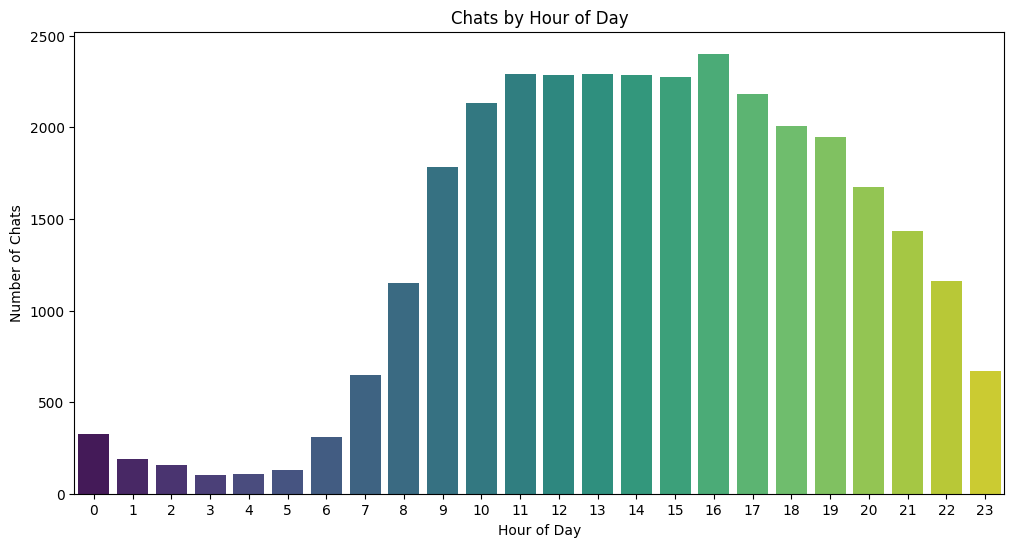

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.histplot(test_data['Chat Duration Seconds'].dropna(), bins=50, kde=True)
plt.title('Distribution of Chat Duration (seconds)')
plt.xlabel('Chat Duration (seconds)')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(10, 6))
sns.countplot(y='Teams', data=test_data, order=test_data['Teams'].value_counts().index)
plt.title('Chats by Teams')
plt.xlabel('Count')
plt.ylabel('Teams')
plt.show()


test_data['hour'] = test_data['Transaction Start Date'].dt.hour

plt.figure(figsize=(12, 6))
sns.countplot(x='hour', data=test_data, palette='viridis')
plt.title('Chats by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Chats')
plt.xticks(range(0, 24))
plt.show()


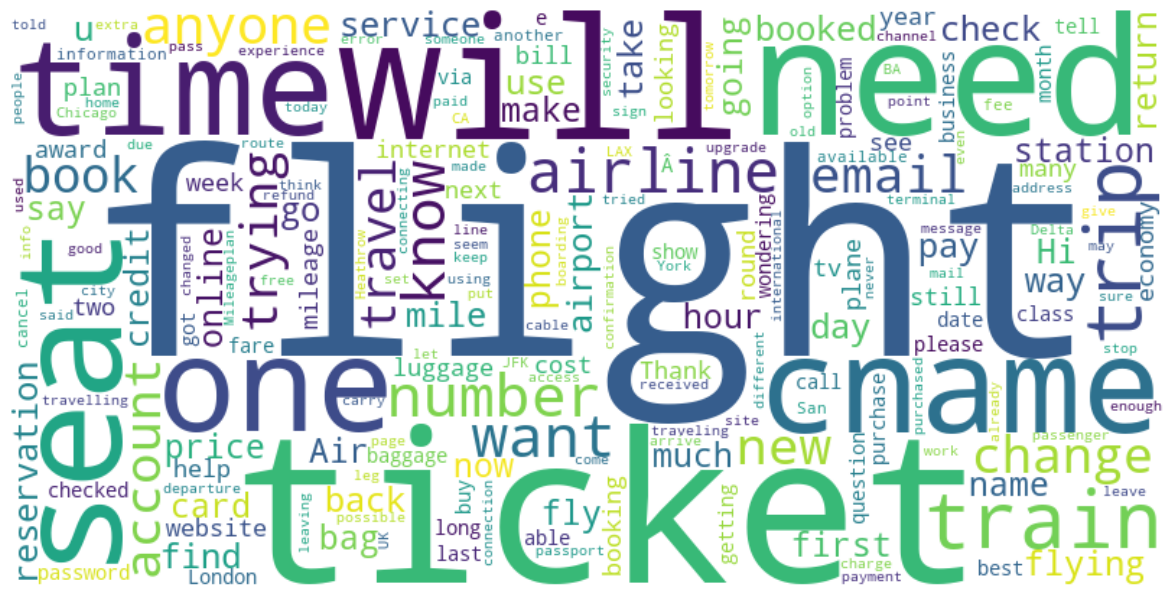

In [15]:
combined_text = " ".join([str(x) for x in test_data['Text'].dropna()])

stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=800,
                      height=400,
                      background_color="white",
                      stopwords=stopwords,
                      collocations=False).generate(combined_text)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## Perform Analysis Using Deep Learning Models of your Choice, Present Discussion, and Conclusions (65 points)
_Start the main analysis (the main analysis refers to supervised learning tasks such as classification or regression). Depending on your project, you may have one model or more. Generally, it is deemed a higher quality project if you compare multiple models and show your understanding of why specific models work better than the other or what limitations or cautions specific models may have. For machine learning models, another recommendation is to show enough effort on the hyperparameter optimization._

Convert the pandas DataFrame to a Hugging Face Dataset and map the sentiment labels to integers:


In [ ]:
dataset = Dataset.from_pandas(train_data)

label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}

def encode_labels(example):
    example["label"] = label2id[example["sentiment"]]
    return example

dataset = dataset.map(encode_labels)


Create an uncased BERT (stands for "Bidirectional Encoder Representations from Transformers" and is widely used in NLP due to its strong contextual representation capabilities) model:

In [ ]:
model_name = "bert-base-uncased"
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}


model = TFAutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)


Create a tokenized (transforms raw text into a structured, numerical format that enables the deep learning model to process and learn from the data effectively) test and training dataset

In [ ]:
split_dataset = dataset.train_test_split(test_size=0.2)
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["message"], truncation=True, padding="max_length", max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

tokenized_train_dataset = tokenized_train_dataset.rename_column("label", "labels")
tokenized_val_dataset = tokenized_val_dataset.rename_column("label", "labels")



Compile baseline BERT model before hyperparamater tuning:

In [44]:
# takes 10 minutes
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
tf.keras.backend.set_value(model.optimizer.learning_rate, 2e-5)

def dataset_to_tf(dataset, batch_size, shuffle=False):
    return dataset.to_tf_dataset(
        columns=["input_ids", "attention_mask", "labels"],
        shuffle=shuffle,
        batch_size=batch_size,
    )

batch_size = 16
tf_train_dataset = dataset_to_tf(tokenized_train_dataset, batch_size=batch_size, shuffle=True)
tf_val_dataset = dataset_to_tf(tokenized_val_dataset, batch_size=batch_size, shuffle=False)

history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=3)
print("Baseline training history:", history.history)

eval_results = model.evaluate(tf_val_dataset)
print("Baseline evaluation results:", eval_results)


Epoch 1/3
30/30 [==============================] - 149s 5s/step - loss: 0.9567 - accuracy: 0.5418 - val_loss: 0.8299 - val_accuracy: 0.6325
Epoch 2/3
30/30 [==============================] - 131s 4s/step - loss: 0.5655 - accuracy: 0.8223 - val_loss: 0.4079 - val_accuracy: 0.9145
Epoch 3/3
30/30 [==============================] - 234s 8s/step - loss: 0.2356 - accuracy: 0.9593 - val_loss: 0.2164 - val_accuracy: 0.9316
Baseline training history: {'loss': [0.9566630125045776, 0.5654832124710083, 0.2356044501066208], 'accuracy': [0.5417559146881104, 0.8222697973251343, 0.95931476354599], 'val_loss': [0.8298714756965637, 0.40792927145957947, 0.21640031039714813], 'val_accuracy': [0.632478654384613, 0.9145299196243286, 0.9316239356994629]}
8/8 [==============================] - 19s 2s/step - loss: 0.2164 - accuracy: 0.9316
Baseline evaluation results: [0.21640031039714813, 0.9316239356994629]


Hyperparameter tuning by converting the Hugging Face dataset to a tf.data.Dataset that can be used with TensorFlow and then use Optuna to suggest and evaluate different hyperparameter configurations by training a fresh model for each trial and measuring its validation loss:

In [46]:
#takes 180 minutes

tokenized_train_dataset.set_format("tensorflow")
tokenized_val_dataset.set_format("tensorflow")

def dataset_to_tf(dataset, batch_size, shuffle=False):
    return dataset.to_tf_dataset(
        columns=["input_ids", "attention_mask", "labels"],
        shuffle=shuffle,
        batch_size=batch_size,
    )

def objective(trial):
    num_train_epochs = trial.suggest_int("num_train_epochs", 2, 5)
    per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32])
    learning_rate = trial.suggest_float("learning_rate", 5e-6, 5e-5, log=True)

    model = TFAutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=3,
        id2label=id2label,
        label2id=label2id
    )
    
    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )
    tf.keras.backend.set_value(model.optimizer.learning_rate, learning_rate)
    
    tf_train_dataset = dataset_to_tf(tokenized_train_dataset, batch_size=per_device_train_batch_size, shuffle=True)
    tf_val_dataset = dataset_to_tf(tokenized_val_dataset, batch_size=per_device_train_batch_size, shuffle=False)
    history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=num_train_epochs, verbose=0)
    eval_loss = history.history["val_loss"][-1]
    return eval_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Best hyperparameters:", study.best_trial.params)

[I 2025-02-20 14:07:26,936] A new study created in memory with name: no-name-20e6b257-0733-4c74-8548-53d34018bf1c
[I 2025-02-20 14:14:06,077] Trial 0 finished with value: 0.6572226881980896 and parameters: {'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'learning_rate': 6.110352850031888e-06}. Best is trial 0 with value: 0.6572226881980896.
[I 2025-02-20 14:18:21,462] Trial 1 finished with value: 0.29977065324783325 and parameters: {'num_train_epochs': 2, 'per_device_train_batch_size': 32, 'learning_rate': 4.875249296698081e-05}. Best is trial 1 with value: 0.29977065324783325.
[I 2025-02-20 14:28:55,573] Trial 2 finished with value: 0.43665552139282227 and parameters: {'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'learning_rate': 4.2489830237057495e-05}. Best is trial 1 with value: 0.29977065324783325.
[I 2025-02-20 14:37:52,851] Trial 3 finished with value: 0.7595667243003845 and parameters: {'num_train_epochs': 2, 'per_device_train_batch_size': 32, 'learning_

Best hyperparameters: {'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'learning_rate': 7.855268775040922e-06}


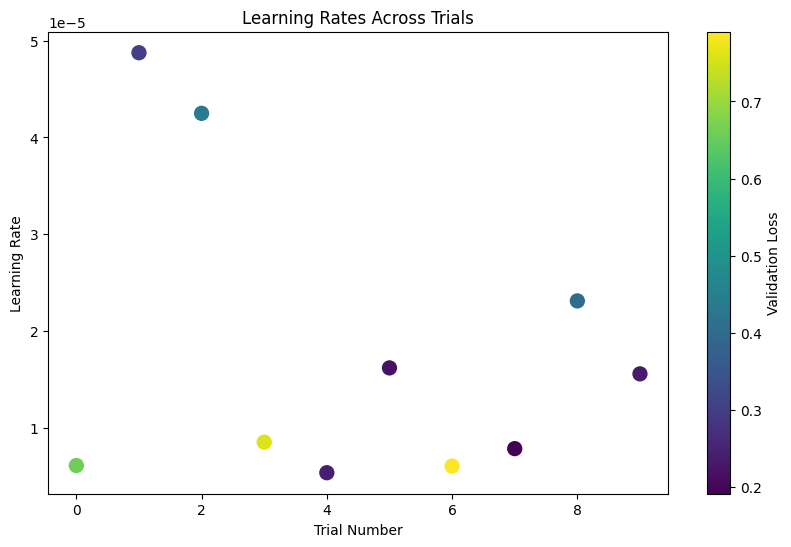

In [47]:
trial_numbers = [trial.number for trial in study.trials]
learning_rates = [trial.params.get('learning_rate', None) for trial in study.trials]
eval_losses = [trial.value for trial in study.trials]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(trial_numbers, learning_rates, c=eval_losses, cmap='viridis', s=100)
plt.xlabel("Trial Number")
plt.ylabel("Learning Rate")
plt.title("Learning Rates Across Trials")
cbar = plt.colorbar(scatter)
cbar.set_label("Validation Loss")
plt.show()


Take the best hyperparameters and then use them to train a new model that classifies the chat new data:

In [54]:

best_params = study.best_trial.params
print("Best hyperparameters:", best_params)

model = TFAutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
tf.keras.backend.set_value(model.optimizer.learning_rate, best_params["learning_rate"])

final_batch_size = best_params["per_device_train_batch_size"]
final_epochs = best_params["num_train_epochs"]

tf_train_dataset = dataset_to_tf(tokenized_train_dataset, batch_size=final_batch_size, shuffle=True)

model.fit(tf_train_dataset, epochs=final_epochs)


test_texts = [str(text) for text in test_data["Text"].fillna("").tolist()]

test_inputs = tokenizer(
    test_texts,
    truncation=True,
    padding="max_length",
    max_length=128,
    return_tensors="tf"
)

predictions = model.predict(test_inputs).logits

predicted_class_ids = tf.argmax(predictions, axis=-1).numpy()

predicted_sentiments = [id2label[int(class_id)] for class_id in predicted_class_ids]

test_data["predicted_sentiment"] = predicted_sentiments

print(test_data.head())


Best hyperparameters: {'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'learning_rate': 7.855268775040922e-06}
Epoch 1/5
59/59 [==============================] - 97s 1s/step - loss: 1.0545 - accuracy: 0.4561
Epoch 2/5
59/59 [==============================] - 81s 1s/step - loss: 0.7149 - accuracy: 0.8501
Epoch 3/5
59/59 [==============================] - 81s 1s/step - loss: 0.3064 - accuracy: 0.9507
Epoch 4/5
59/59 [==============================] - 82s 1s/step - loss: 0.1558 - accuracy: 0.9764
Epoch 5/5
999/999 [==============================] - 8051s 8s/step
  Transaction Start Date     Agent Chat Duration                  Teams  \
0    2018-06-08 23:59:00      Zaha      00:18:22    Mobile Service Team   
1    2018-06-08 23:59:00  Berenice      00:03:05  Mobile Technical Team   
2    2018-06-08 23:59:00      Madi      00:22:33    Mobile Service Team   
3    2018-06-08 23:59:00      Rose      00:38:20    Mobile Service Team   
4    2018-06-08 23:59:00    Sarrah      00:11:50  

Analysis of chats by sentiment: 

negative    16513
neutral     13386
positive     2053
Name: predicted_sentiment, dtype: int64


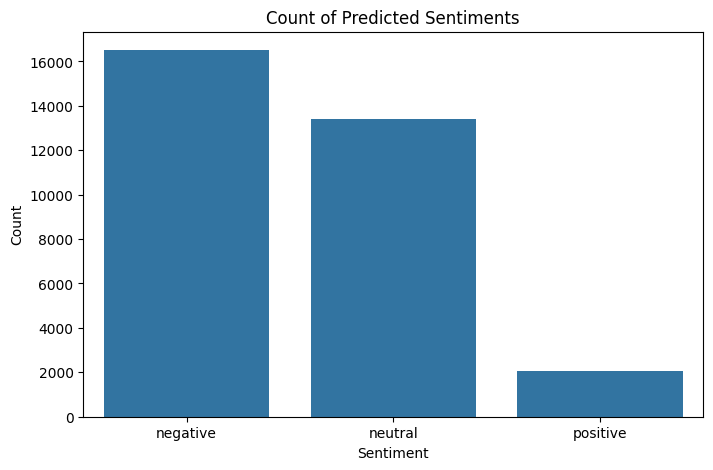

In [56]:
print(test_data["predicted_sentiment"].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(x="predicted_sentiment", data=test_data, order=test_data["predicted_sentiment"].value_counts().index)
plt.title("Count of Predicted Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


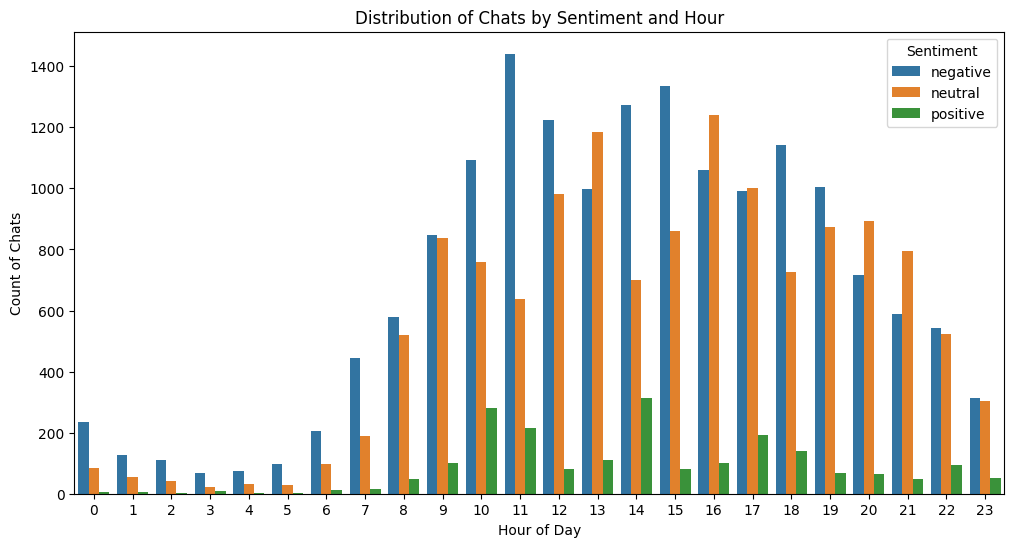

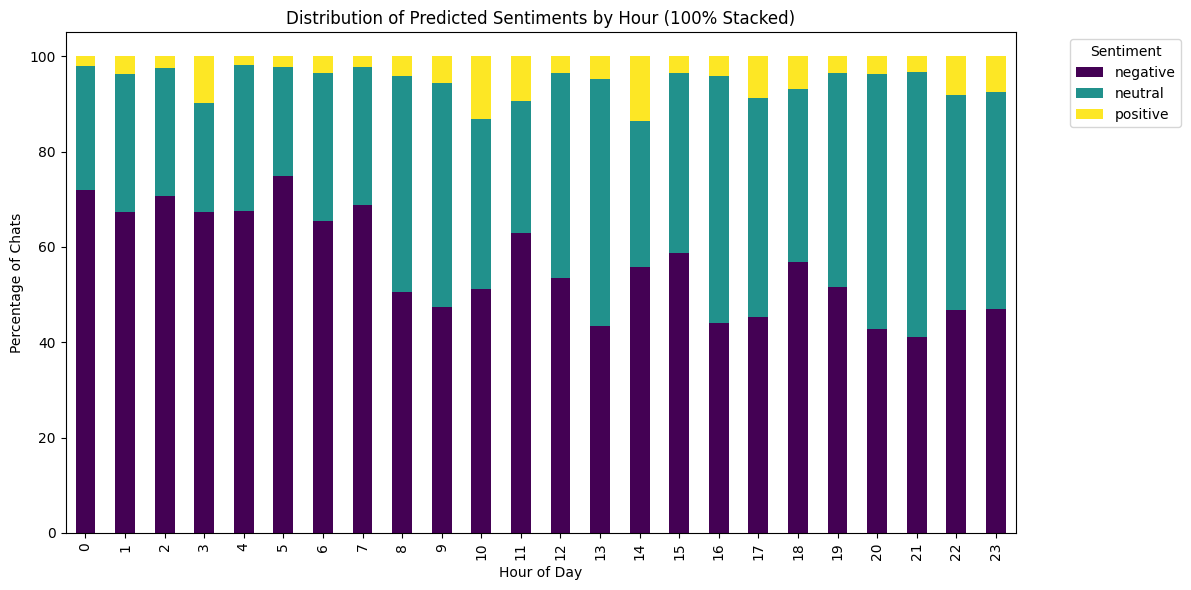

In [60]:
plt.figure(figsize=(12, 6))
sns.countplot(x="hour", hue="predicted_sentiment", data=test_data, order=range(24))
plt.title("Distribution of Chats by Sentiment and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Count of Chats")
plt.legend(title="Sentiment")
plt.show()

sentiment_counts = test_data.groupby(["hour", "predicted_sentiment"]).size().reset_index(name="count")
pivot_df = sentiment_counts.pivot(index="hour", columns="predicted_sentiment", values="count").fillna(0)
pivot_percent = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
pivot_percent.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")

plt.title("Distribution of Predicted Sentiments by Hour (100% Stacked)")
plt.xlabel("Hour of Day")
plt.ylabel("Percentage of Chats")
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Conclusion
I developed a sentiment analysis pipeline using pre-trained transformer models to assess the emotional tone of customer service chats. By fine-tuning a BERT-based model on sentiment-labeled datasets and leveraging hyperparameter tuning with Optuna, I optimized the model to accurately distinguish between positive, neutral, and negative interactions. Once tuned, the final model was deployed to predict sentiment on real-world chat data, allowing us to automatically identify chats that may require urgent escalation. This approach not only streamlines the triage process but also enhances the overall customer support experience by ensuring that dissatisfied customers receive timely attention.